<b> Concept Tagging </b>

What are the concepts that the presidential candidates focus on the most? How effectively do they convey these ideas?

In [1]:
import MySQLdb as mdb
import sys
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize

# Connect to the MySQL database
con = mdb.connect(host = 'localhost', 
                  user = 'root', 
                  passwd = 'dwdstudent2015', 
                  charset= 'utf8', use_unicode=True);

# Query to create a database
db_name = 'candidates'
create_db_query = "CREATE DATABASE IF NOT EXISTS {0} DEFAULT CHARACTER SET 'utf8'".format(db_name)

# Create a database
cursor = con.cursor()
cursor.execute(create_db_query)
cursor.close()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: Warning: Can't create database 'candidates'; database exists


In [2]:
# Now we will create a table to store the URLs and the entities
# extracted from these URLs

cursor = con.cursor()
table_name = 'concepts'
# Create a table
# The {0} and {1} are placeholders for the parameters in the format(....) statement
create_table_query = '''CREATE TABLE IF NOT EXISTS {0}.{1} 
                                (name varchar(250),
                                url varchar(250), 
                                concept varchar(250),
                                relevance varchar(250)
                                )'''.format(db_name, table_name)
cursor.execute(create_table_query)
cursor.close()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: Warning: Table 'concepts' already exists


In [3]:
def analyzeText(url):
    api_url = "http://gateway-a.watsonplatform.net/calls/url/URLGetRankedConcepts"
    api_key = 'e4224475655b67b9a20148829e3313d58f5867e0'
    headers = {
        "Accept": "application/json"
    }
    parameters = {
        'outputMode': 'json',
        'apikey' : api_key,
        'sentiment' : 1,
        'knowledgeGraph': 0,
        'url': url
    }
    resp = requests.post(api_url, params=parameters, headers=headers)
    data = json.loads(resp.text)
    
    if len(data["concepts"]) == 0:
        return None
    
    df = json_normalize(data["concepts"])
    
    # We do a little bit of housecleaning and define 
    # proper data types for the data frame column
    df["relevance"] = pandas.to_numeric(df["relevance"])
    
    return df
    #return data


In [4]:
import requests
import json

# This is the query template for entering entities, URLs, and other
# data into our database

def insertInDB(name, url):
    query_template = '''INSERT INTO 
        candidates.concepts(name, url, concept, relevance) 
        VALUES (%s, %s, %s, %s)'''

    cursor = con.cursor()
    
    # We get the entities from Alchemy API
    # in the form of a DataFrame
    results = analyzeText(url) 
    
    # check for exception
    if results is None:
        cursor.close()
        return
    
    
    # We iterate over the rows of the Dataframe
    # using the iterrows() command.
    for i, row in results.iterrows():
        concept = (row["text"]).encode('utf-8')
        relevance = str(row["relevance"])
        print (url, concept, relevance)

        query_parameters = (name, url, concept, relevance)
        cursor.execute(query_template, query_parameters)

    con.commit()
    cursor.close()


In [5]:
def deleteDatabaseTable(databaseName, tableName):
    query_template = '''DELETE FROM {0}.{1}'''
    cursor = con.cursor()
    cursor.execute(query_template.format(databaseName, tableName))

    con.commit()
    cursor.close()

In [6]:
import pandas
# urls for Trump
trump_urls = [
 'https://www.donaldjtrump.com/positions/pay-for-the-wall',
 'https://www.donaldjtrump.com/positions/healthcare-reform',
 'https://www.donaldjtrump.com/positions/us-china-trade-reform',
 'https://www.donaldjtrump.com/positions/veterans-administration-reforms',   
 'https://www.donaldjtrump.com/positions/tax-reform',
 'https://www.donaldjtrump.com/positions/second-amendment-rights',
 'https://www.donaldjtrump.com/positions/immigration-reform' 
]

#urls for Sanders
sanders_urls = [
 'https://berniesanders.com/issues/income-and-wealth-inequality/',
 'https://berniesanders.com/issues/its-time-to-make-college-tuition-free-and-debt-free/',
 'https://berniesanders.com/issues/money-in-politics/',
 'https://berniesanders.com/issues/creating-jobs-rebuilding-america/',   
 'https://berniesanders.com/issues/a-living-wage/',
 'https://berniesanders.com/people-before-polluters/', 
 'https://berniesanders.com/a-fair-and-humane-immigration-policy/',
 'https://berniesanders.com/issues/racial-justice/',
 'https://berniesanders.com/issues/fighting-for-affordable-housing/',
 'https://berniesanders.com/issues/fighting-for-womens-rights/',
 'https://berniesanders.com/issues/hiv-and-aids/',
 'https://berniesanders.com/issues/fighting-for-lgbt-equality/',
 'https://berniesanders.com/issues/empower-tribal-nations/',
 'https://berniesanders.com/issues/caring-for-our-veterans/',
 'https://berniesanders.com/medicareforall/',
 'https://berniesanders.com/issues/strengthen-and-expand-social-security/',
 'https://berniesanders.com/issues/fighting-to-lower-prescription-drug-prices/',
 'https://berniesanders.com/issues/fighting-for-disability-rights/',
 'https://berniesanders.com/issues/puerto-rico/',
 'https://berniesanders.com/issues/general-electric-must-pay-restore-hudson-river/',
 'https://berniesanders.com/issues/constitution-pipeline-must-defeated/',
 'https://berniesanders.com/issues/supporting-historically-black-colleges-and-universities-and-minority-serving-institutions/',
 'https://berniesanders.com/issues/ending-the-race-to-the-bottom/',
 'https://berniesanders.com/issues/native-hawaiians/',
 'https://berniesanders.com/issues/improving-the-rural-economy/',
 'https://berniesanders.com/issues/fighting-for-nurses/',
 'https://berniesanders.com/issues/reforming-wall-street/',
 'https://berniesanders.com/issues/real-family-values/',
 'https://berniesanders.com/issues/war-and-peace/',
 'https://berniesanders.com/issues/war-should-be-the-last-option/',
 'https://berniesanders.com/issues/making-the-wealthy-pay-fair-share/',
 'https://berniesanders.com/issues/how-bernie-pays-for-his-proposals/'
]

deleteDatabaseTable('candidates', 'concepts')

#populate Trump data
for url in trump_urls:
    insertInDB('Trump', url)

#populate Sanders data
for url in sanders_urls:
    insertInDB('Sanders', url)    

('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'United States', '0.978416')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Mexico', '0.962279')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Immigration to the United States', '0.671582')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'International trade', '0.581311')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Humid subtropical climate', '0.579985')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Illegal immigration', '0.577047')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Poverty in the United States', '0.527347')
('https://www.donaldjtrump.com/positions/pay-for-the-wall', 'Plurality voting system', '0.527073')
('https://www.donaldjtrump.com/positions/healthcare-reform', 'Health care', '0.956707')
('https://www.donaldjtrump.com/positions/healthcare-reform', 'Free market', '0.860084')
('https://www.donaldjtrump.com/positions/healthcare

In [7]:
import pandas as pd

#selecting all Trump entries
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT name, concept, MAX(relevance) AS relevance FROM candidates.concepts GROUP BY concept  HAVING name = 'Trump' ORDER BY relevance DESC")
rows = cur.fetchall()
df_from_sql_trump = pd.DataFrame(list(rows))
df_from_sql_trump.reindex(columns=pd.Index(['name']).append(df_from_sql_trump.columns.difference(['name'])))


name                                            concept relevance
0   Trump                                International trade  0.980447
1   Trump                                      United States  0.978416
2   Trump               Concealed carry in the United States  0.972186
3   Trump       United States Department of Veterans Affairs  0.968024
4   Trump                                             Mexico  0.962279
5   Trump                                                Tax  0.961256
6   Trump                                        Health care  0.956707
7   Trump                   Immigration to the United States  0.954305
8   Trump                      Taxation in the United States  0.938448
9   Trump                                   Health insurance  0.905758
10  Trump                                        Free market  0.860084
11  Trump                                            Firearm  0.848099
12  Trump                           World Trade Organization  0.815826
13  Trump                                           Taxation  0.749371
14  Trump                                             Health  0.733024
15  Trump                                    Progressive tax   0.72418
16  Trump                                      Public health  0.679573
17  Trump                                          Insurance  0.668421
18  Trump                                       Donald Trump  0.656449
19  Trump                                Illegal immigration  0.655046
20  Trump                                       Barack Obama   0.65199
21  Trump                                   Economic freedom  0.628089
22  Trump                                        Immigration  0.617964
23  Trump                                         Income tax  0.583665
24  Trump                                         Free trade  0.581052
25  Trump                          Humid subtropical climate  0.579985
26  Trump                     Veterans Health Administration    0.5698
27  Trump                                            Veteran  0.568798
28  Trump                                        Ivana Trump    0.5522
29  Trump                  Gun politics in the United States  0.539775
30  Trump                       Poverty in the United States  0.538188
31  Trump                                    Immigration law  0.537143
32  Trump                                              VistA    0.5346
33  Trump                            Plurality voting system  0.527073
34  Trump                                      Corporate tax  0.522659
35  Trump                North American Free Trade Agreement  0.513495
36  Trump                                         Tax refund  0.489202
37  Trump                                              Alien  0.479184
38  Trump                                       Gun politics  0.475473
39  Trump                                             Export  0.468731
40  Trump                                               Gang  0.453153
41  Trump                                     European Union   0.42633
42  Trump           Illegal immigration to the United States   0.42342
43  Trump                                              China  0.413673
44  Trump                                              Crime  0.404259
45  Trump                        Right to keep and bear arms  0.396343
46  Trump  Second Amendment to the United States Constitu...  0.383025
47  Trump                                      Violent crime  0.370242
48  Trump                    Income tax in the United States  0.322222

In [8]:
import pandas as pd

#selecting all Sanders entries
cur = con.cursor(mdb.cursors.DictCursor)
cur.execute("SELECT name, concept, MAX(relevance) AS relevance FROM candidates.concepts GROUP BY concept  HAVING name = 'Sanders' ORDER BY relevance DESC")
rows = cur.fetchall()
df_from_sql_sanders = pd.DataFrame(list(rows))
df_from_sql_sanders.reindex(columns=pd.Index(['name']).append(df_from_sql_sanders.columns.difference(['name'])))

name                                       concept relevance
0    Sanders                             Domestic violence  0.988103
1    Sanders                                    University   0.98472
2    Sanders                                       Pension  0.982173
3    Sanders                                         Leave  0.981763
4    Sanders                              African American  0.979283
5    Sanders  Historically black colleges and universities  0.975245
6    Sanders                                 Homosexuality  0.971712
7    Sanders                                   Puerto Rico  0.971328
8    Sanders         Native Americans in the United States  0.969765
9    Sanders                                    Disability  0.967865
10   Sanders                                  Hudson River  0.966426
11   Sanders                                   Fossil fuel  0.963398
12   Sanders                                  Pharmacology  0.962178
13   Sanders                                Nuclear weapon  0.959578
14   Sanders                                   Real estate   0.95705
15   Sanders                                          Bank  0.956708
16   Sanders                                   Natural gas   0.95585
17   Sanders                                  Minimum wage  0.954803
18   Sanders                                      Medicine  0.950695
19   Sanders                                Drinking water  0.949758
20   Sanders                                       Nursing    0.9497
21   Sanders                                    Wind power  0.947078
22   Sanders                                      Iraq War  0.936867
23   Sanders                                  Homelessness  0.936007
24   Sanders                                  World War II  0.935961
25   Sanders                           Economic inequality  0.928759
26   Sanders                                    Employment  0.925823
27   Sanders                                        Police  0.922568
28   Sanders                        Distribution of wealth  0.904629
29   Sanders                                        Wealth  0.897698
..       ...                                           ...       ...
139  Sanders                                 Welfare state  0.538261
140  Sanders                             Public university  0.535466
141  Sanders          Family and Medical Leave Act of 1993   0.53046
142  Sanders                                      New York  0.529469
143  Sanders                              Employee benefit  0.524498
144  Sanders                             Prescription drug  0.520578
145  Sanders                             Education finance  0.516849
146  Sanders                                           Law  0.515327
147  Sanders         Higher education in the United States  0.503568
148  Sanders                         Schenectady, New York  0.501934
149  Sanders                               Human migration  0.501709
150  Sanders                        Wilberforce University  0.499902
151  Sanders                                       Old age  0.498909
152  Sanders                                        Niihau  0.496451
153  Sanders                            Alternative energy   0.49275
154  Sanders                                       Holiday  0.490434
155  Sanders                          Puerto Rican Spanish  0.490001
156  Sanders                      Internal Revenue Service  0.488499
157  Sanders                           Pharmaceutical drug  0.479873
158  Sanders                                  Central bank  0.458374
159  Sanders               National pharmaceuticals policy  0.455407
160  Sanders                                        Infant  0.452548
161  Sanders                               Monetary policy  0.438917
162  Sanders                                Regressive tax  0.431867
163  Sanders                 Financial crisis of 2007–2010  0.430218
164  Sanders                              Proportional tax  0.423383
165  S

<b> Table Analysis </b>

Trump's top 3 concepts include:
1) International Trade
2) United States
3) Concealed Carry in the United States

Sanders's top concepts include:
1) Domestic Violence
2) University
3) Pension 

Trump's concepts indeed cover traditionally republican topics whereas Sanders emphasizes on issues facing smaller underrepresented groups.

Notice the repetition of the 'United States' in Trump's top concepts -> strong support of American exceptionalism. Consistent with Trump's belief that its a zero sum game; only one can have it good and it should be the United States.

Concept Relevance Analysis - Trump


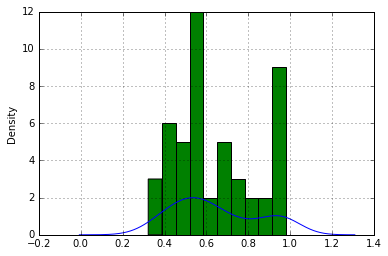

In [9]:
print "Concept Relevance Analysis - Trump"
%matplotlib inline
df_from_sql_trump["relevance"] = pandas.to_numeric(df_from_sql_trump["relevance"])
plt2 = df_from_sql_trump["relevance"].plot(kind='kde')
df_from_sql_trump["relevance"].hist(ax=plt2)

Concept Relevance Analysis - Sanders


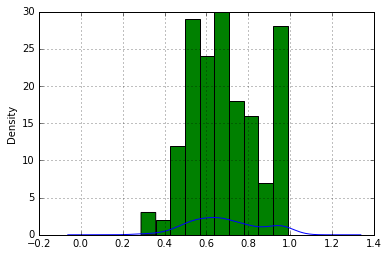

In [10]:
print "Concept Relevance Analysis - Sanders"
%matplotlib inline
df_from_sql_sanders["relevance"] = pandas.to_numeric(df_from_sql_sanders["relevance"])
plt2 = df_from_sql_sanders["relevance"].plot(kind='kde')
df_from_sql_sanders["relevance"].hist(ax=plt2)

<b> Graph Analysis </b>

Based on the density and the number of 'concepts' with the highest relevance, it seems that Bernie is more encompassing with his campaign as he presents more relevant arguments on different topics whereas Trump touches less topics. Bernie hits almost 25 concepts ranked near 1.0 relevance whereas Trump only hits 9 with the same relevancy. In terms of the concepts presented, Bernie seems to be more focused in his writing as most of his concepts are above 0.5 in relevancy whereas for Trump, there is a lot below 0.5.